In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from shapely.geometry import Point, LineString, Polygon
import numpy as np
import torch

#code for inference input
def ffsGeo(Ho, Lo):
    xMax = 12
    xMin = -6
    Wo = 0.1
    bPoints = [Point(xMin,0.5), Point(-Lo,0.5), Point(-Lo,0.5-Ho), Point(-Lo+Wo,0.5-Ho), Point(-Lo+Wo,0.5),  Point(0, 0.5), Point(0,0), Point(xMax,0), Point(xMax, -0.5), Point(xMin, -0.5), Point(xMin,0.5)]
    geo = Polygon(bPoints)
    boundary = LineString(bPoints)
    return {'boundary': boundary, 'geo': geo} 

def signed_distance(p, shape):
    pt = Point(p)
    d = pt.distance(shape['boundary'])
    return d if shape['geo'].contains(pt) else -d

def evalPointCloud(xMin, xMax, Ho, Lo, totalPoints):

    # Step 1: Generate the full point cloud
    # Aspect ratio
    aspect = xMax-xMin / 1

    # Determine grid size
    Ny = int(np.sqrt(totalPoints / aspect))
    Nx = int(totalPoints / Ny)

    # Domain to evaluate
    x = np.linspace(xMin, xMax, Nx)
    y = np.linspace(-0.5, 0.5, Ny)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Step 2: Compute and store baseline SDF (no obstacle)
    # This polygon has just the outer rectangle
    geo = ffsGeo(Ho=Ho, Lo=Lo)
    sdf = np.array([signed_distance(p, geo) for p in points])

    mask = (sdf>=0)
    insidePoints = points[mask]
    insideSdf = sdf[mask]

    return {'input_feat': torch.tensor(insideSdf, dtype=torch.float32), 'input_pos': torch.tensor(insidePoints, dtype=torch.float32)}


In [ ]:
Ho = 0.2 # 0.1 - 0.5
Lo = 0.5 # 0.2 - 1
re = 500
xMin = train_dataset.crop_values[0][0]
xMax = train_dataset.crop_values[1][0]
totalPoints = 4096*4
numSupernodes = 512

pointCloud = evalPointCloud(xMin=xMin, xMax=xMax, Ho=Ho, Lo=Lo, totalPoints=totalPoints)

re = torch.tensor([re])

In [ ]:
#normalize
input_feat = train_dataset.normalize_sdf(pointCloud['input_feat'])
input_pos = train_dataset.normalize_pos(pointCloud['input_pos'])
re = train_dataset.normalize_re(re)

# select supernodes
rng = torch.Generator().manual_seed(1)
supernode_idxs = torch.randperm(len(input_feat), generator=rng)[:numSupernodes]

#create batch index
batch_idx = torch.zeros([len(input_feat)], dtype=int)
# batch_idx = np.ones([len(input_feat), 1])

input_feat = input_feat.unsqueeze(1)
output_pos = input_pos.unsqueeze(0)

inferenceInput =  dict(
        input_feat=input_feat,
        input_pos=input_pos,
        supernode_idxs=supernode_idxs,
        batch_idx=batch_idx,
        output_pos=output_pos,
        re=re,
    )

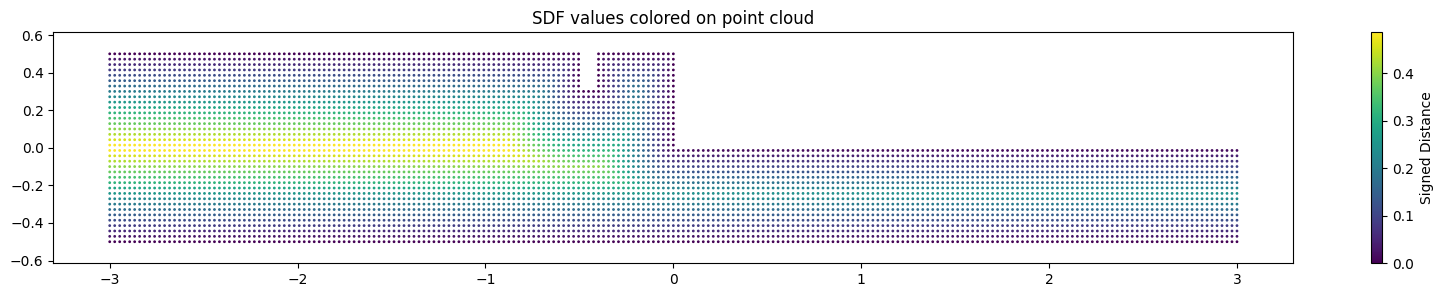

In [288]:
input_pos = pointCloud['input_pos']
input_feat = pointCloud['input_feat']
# Visualize
plt.figure(figsize=(20, 3))
plt.scatter(input_pos[:, 0], input_pos[:, 1], c=input_feat, s=1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

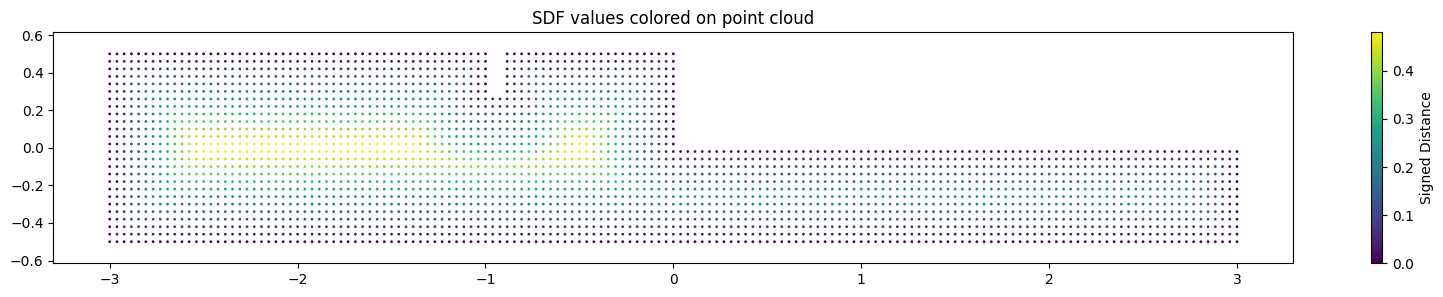

In [272]:
insideMask = (base_sdf>=0)
insidePoints = points[insideMask]
insideSdf = base_sdf[insideMask]
# Visualize
plt.figure(figsize=(20, 3))
plt.scatter(insidePoints[:, 0], insidePoints[:, 1], c=insideSdf, s=1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

In [3]:
directory = './data/ffs/preprocessed/DP1_718,18181818181733-0,43636363636363645-0,10181818181818182/'
mesh_tensor = torch.load('/workspace/upt-tutorial/data/simulation/case_000000/00000000_mesh.th', weights_only=True)

In [4]:
mesh_tensor.shape

torch.Size([3, 32392])

In [11]:
sdf = torch.load(uri.replace('CSV', 'preprocessed').replace('.csv', '/') + 'mesh_sdf.th', weights_only=True)
mesh_pos = torch.load(uri.replace('CSV', 'preprocessed').replace('.csv', '/') + 'mesh_points.th', weights_only=True)


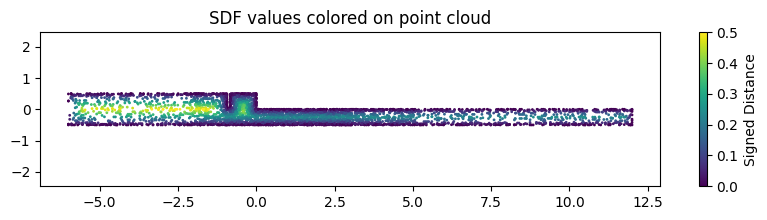

In [ ]:
# Visualize
plt.figure(figsize=(10, 2))
plt.scatter(input_pos[:, 0], input_pos[:, 1], c=input_feat, s=1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

In [1]:
from upt.datasets.ffs_dataset import ffsDataset
import torch
import matplotlib.pyplot as plt
import numpy as np

num_test_inputs  = 4096
num_test_outputs = 4096
# num_train_inputs  = 8192
# num_train_outputs = 16000

num_train_inputs  = num_test_inputs 
num_train_outputs = num_test_outputs

crop_values= [[-3, -2], [3, 2]]

# initialize dataset
train_dataset = ffsDataset(
    root="./data/ffs/preprocessed",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_train_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_train_outputs,
    # mode
    mode="train",
    # crop
    crop_values= None,
)

In [ ]:
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

testvis_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=512, deterministic=True),
)
data = [d for d in iter(testvis_dataloader)]

In [3]:
sample = train_dataset[0]

In [ ]:
sample[]

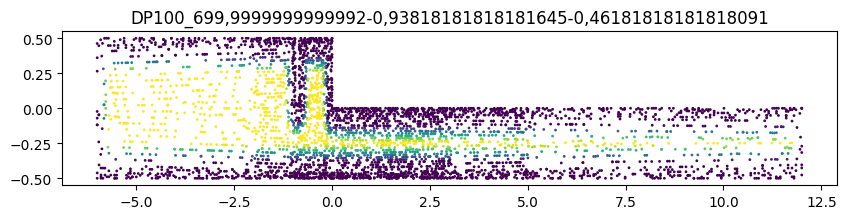

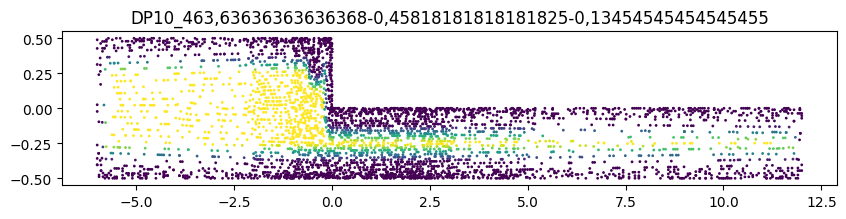

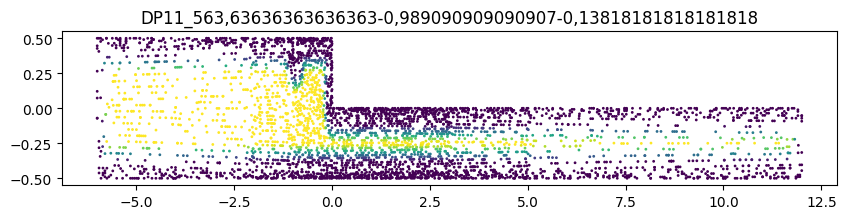

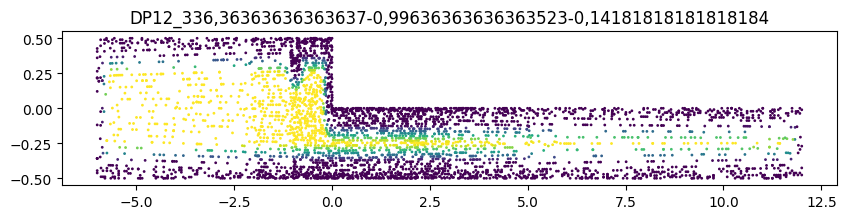

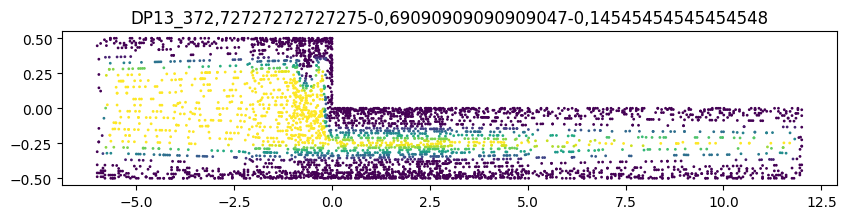

In [6]:
for i in range(5):
    sample = train_dataset[i]
    # plot sparse
    x_pos, y_pos = train_dataset.denormalize_pos(sample["input_pos"]).unbind(1)
    target = train_dataset.denormalize_feat(sample["target_feat"]).clamp(0, 1)
    sdf = sample["input_feat"].clamp(0, 1)
    target = target[:,0]

    plt.figure(figsize=(10, 2))
    plt.title(sample["name"])
    plt.scatter(x_pos, y_pos, c=sdf, marker="o", s=1)
    plt.show()

In [5]:
# Load tensor data
directory = '../data/ffs/preprocessed/'
coords_norm = torch.load(directory + 'coords_norm.th')
vars_norm = torch.load(directory + 'vars_norm.th')

/tmp/ipykernel_373902/1446659531.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coords_norm = torch.load(directory + 'coords_norm.th')
/tmp/ipykernel_373902/1446659531.

In [ ]:
#Save to matlab format
import scipy.io as sio

saveDir = './data/ffs/mat/'


sio.savemat(saveDir + directory.split('/')[-2] + '.mat', dataDict)

In [16]:
from pathlib import Path
import os

uris = []
root = Path('./data/ffs/preprocessed/')

for name in sorted(os.listdir(root)):
    sampleDir = root / name
    if sampleDir.is_dir():
        uris.append(sampleDir)

In [20]:
sum_vars = 0.0
sum_sq_vars = 0.0
total_samples = 0
for uri in uris:
    sdf = torch.load(uri / 'mesh_sdf.th', weights_only=True)
    sum_vars += sdf.sum()
    sum_sq_vars += (sdf ** 2).sum()
    total_samples += len(sdf)
mean_vars = sum_vars / total_samples
std_vars = torch.sqrt((sum_sq_vars / total_samples) - (mean_vars ** 2))
other = torch.load(root/'vars_norm.th', weights_only=True)
other['mean'][-1] = mean_vars
other['std'][-1] = std_vars
torch.save(other, root/"vars_norm.th")


In [17]:
other = torch.load(root/'vars_norm.th', weights_only=True)


In [22]:
other['std'][:-1]

tensor([1.2631, 0.1441, 4.7381])